# AirBnB Seattle Review Analysis
---

## Table of Contents

* [Data Gathering](#Data-Gathering)
* [Data Wrangling](#Data-Wrangling)
* [Data Analysis](#Data-Analysis)
* [Summation](#Summation:)

***
 This notebook is an attempt to understand what impacts the reviews of a listing. In other words, what features in a listing determines a high rating and what can Airbnb listers do to improve them. I attempt to this by asking the following  four questions:

> 1. Are there any significant correlations in the data?

> 2. Can we predict the  the review score?

> 3. What features impact the review rating?

> 4. What are the customers saying about high/low rating listings and is there any insight to what impacted review scores?

***

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import random
import string

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import names
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from wordcloud import STOPWORDS, WordCloud
random.seed(21)

%matplotlib inline

***
## Data Gathering

In [2]:
listings  = pd.read_csv('./seattle/listings.csv')
reviews = pd.read_csv('./seattle/reviews.csv')

## Data Wrangling

In [3]:
# Take a peak at the listings data
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [4]:
# Take a look at reviews
reviews.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."


In [5]:
# Set listing_id as index on reviews and id on listings
reviews.set_index('listing_id', inplace=True)
listings.set_index('id', inplace=True)

# Drop all columns except comments in reviews
reviews.drop(['id', 'date', 'reviewer_id', 'reviewer_name'],
             axis=1, inplace=True)

# Set comments to string data type
reviews['comments'] = reviews['comments'].astype(str)

# Ensure both data frames are in sync
reviews = pd.merge(listings, reviews, left_index=True, right_index=True)

In [6]:
# Drop all columns that are not comments on new reviews dataframe
other_cols = reviews.columns.values.tolist()
other_cols = [col for col in other_cols if col != 'comments']
reviews.drop(columns=other_cols, axis=1, inplace=True)

# Remove any Null rows
reviews.dropna(inplace=True)
reviews.columns.values

array(['comments'], dtype=object)

In [7]:
reviews.head(3)

,comments
4291,"We had a great stay in Seattle, great location..."
4291,Greatly enjoyed our quick stay here. We booked...
4291,We had a great experience in Seattle. We enjoy...


I didn't want to exclude the comments columns as they offer distinct insight into the outcome of review scores. So, I conducted sentiment analysis to condense all comments into a single numerical value, namely the positive rating of the analysis. To do so, below are the high-level steps I took:

> 1. Save __listing_id__'s and ensure that they don't repeat.
> 2. Join all comments that were for a single listing.
> 3. Create a dataframe with the unique __listing_id__'s to merge with the listing dataframe.

In [8]:
# Concat all comments per listing_id
reviews_series = reviews.groupby(reviews.index)['comments']

# Save indexes to assign to formulated dataframe
rev_idx = reviews.index.values.tolist()
# Make the index unique
rev_idx = list(set(rev_idx))

# Join all comments into a single field for sentiment analysis
rev_cc = reviews_series.agg(lambda col: ' '.join(col))
reviews_cc = pd.DataFrame(rev_cc, index=rev_idx)
reviews_cc.head()

,comments
2727938,Jessica's place was delightfully cozy and clos...
598023,Jeff is a very friendly host. We had the chanc...
794633,"Great space, good location, gracious host. Le..."
958475,"When we arrived at the Annex, everything was a..."
5308429,The place was super chill. I would totally be ...


In [9]:
# Init Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [10]:
# Create empty column to populate with the generated sentiment scores
listings['sentiment_score'] = np.nan

In [11]:
# Iterate through the joined comments and place the sentiment score in the listings dataframe
for i, _ in reviews_cc.iterrows():
    listings.loc[i, 'sentiment_score'] = sid.polarity_scores(reviews_cc['comments'].loc[i])['pos']

In [12]:
# Sanity Check
listings.head(2)

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,sentiment_score
id,,,,,,,,,,,,,,,,,,,,,
241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,0.309
953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,...,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,0.330


#### Column selection process:
I chose the below columns based on scope and value. Most columns describe, in essence, the same fundamental aspect of the listing i.e location. In order to determine what impacts the overall review score the most, other review scores were imperative to include. 

In [13]:
listings.columns.values

array(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'ameni

In [14]:
df = listings[['host_acceptance_rate', 'host_is_superhost',
               'neighbourhood', 'city', 'property_type',
               'room_type', 'accommodates', 'bathrooms', 'bedrooms',
               'beds', 'price', 'guests_included', 'extra_people',
               'minimum_nights', 'maximum_nights', 'review_scores_accuracy', 'review_scores_cleanliness',
               'review_scores_checkin', 'review_scores_communication',
               'review_scores_location', 'review_scores_value', 'review_scores_rating', 
               'instant_bookable', 'cancellation_policy', 'sentiment_score']]

#### Take deeper look at the data to determine next steps

In [15]:
# Look at the data footprint for missing values etc.
df.describe()

,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,review_scores_rating,sentiment_score
count,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,3818.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3171.000000,3191.000000
mean,3.349398,1.259469,1.307712,1.735394,1.672603,2.369303,780.447617,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,94.539262,0.290809
std,1.977599,0.590369,0.883395,1.139480,1.311040,16.305902,1683.589007,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,6.606083,0.069431
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,20.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,93.000000,0.255000
50%,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1125.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,96.000000,0.296000
75%,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1125.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,99.000000,0.325000
max,16.000000,8.000000,7.000000,15.000000,15.000000,1000.000000,100000.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,0.792000


In [16]:
# Get Missing Values Percentages
df.isnull().sum()/len(df)*100

host_acceptance_rate           20.246202
host_is_superhost               0.052383
neighbourhood                  10.895757
city                            0.000000
property_type                   0.026192
room_type                       0.000000
accommodates                    0.000000
bathrooms                       0.419068
bedrooms                        0.157150
beds                            0.026192
price                           0.000000
guests_included                 0.000000
extra_people                    0.000000
minimum_nights                  0.000000
maximum_nights                  0.000000
review_scores_accuracy         17.234154
review_scores_cleanliness      17.103195
review_scores_checkin          17.234154
review_scores_communication    17.050812
review_scores_location         17.155579
review_scores_value            17.181771
review_scores_rating           16.946045
instant_bookable                0.000000
cancellation_policy             0.000000
sentiment_score 

In [17]:
# Data types
df.dtypes

host_acceptance_rate            object
host_is_superhost               object
neighbourhood                   object
city                            object
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
price                           object
guests_included                  int64
extra_people                    object
minimum_nights                   int64
maximum_nights                   int64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
review_scores_rating           float64
instant_bookable                object
cancellation_policy             object
sentiment_score                float64
dtype: object

In [18]:
# List object columns
object_cols = df.select_dtypes(include=['object']).columns
df[object_cols].head()

,host_acceptance_rate,host_is_superhost,neighbourhood,city,property_type,room_type,price,extra_people,instant_bookable,cancellation_policy
id,,,,,,,,,,
241032,100%,f,Queen Anne,Seattle,Apartment,Entire home/apt,$85.00,$5.00,f,moderate
953595,100%,t,Queen Anne,Seattle,Apartment,Entire home/apt,$150.00,$0.00,f,strict
3308979,100%,f,Queen Anne,Seattle,House,Entire home/apt,$975.00,$25.00,f,strict
7421966,NaN,f,Queen Anne,Seattle,Apartment,Entire home/apt,$100.00,$0.00,f,flexible
278830,NaN,f,Queen Anne,Seattle,House,Entire home/apt,$450.00,$15.00,f,strict


In [19]:
# Suppress notes
pd.options.mode.chained_assignment = None

# Adjust object data to numerical
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['extra_people'] = df['extra_people'].replace('[\$,]', '', regex=True).astype(float)

# Fill NaN's for acceptance_rate since values are already 1 or 0
df['host_acceptance_rate'].fillna(0, inplace=True)

# Dictionary to map 't' to 1 and 'f' to 0:
map_dict = {'t': 1, 'f': 0}

# List columns to adjust:
bool_cols = ['host_is_superhost', 'instant_bookable']

for col in bool_cols:
    df[col] = df[col].map(map_dict)
    
df[bool_cols].head()

,host_is_superhost,instant_bookable
id,,
241032,0.0,0
953595,1.0,0
3308979,0.0,0
7421966,0.0,0
278830,0.0,0


#### Take a look at the other object columns and verify integrity

In [20]:
df['city'].unique()

array(['Seattle', 'Ballard, Seattle', 'West Seattle', 'Seattle ', '西雅图',
       'Phinney Ridge Seattle', 'seattle'], dtype=object)

In [21]:
df['neighbourhood'].unique()

array(['Queen Anne', nan, 'Ballard', 'Phinney Ridge', 'Fremont',
       'Lower Queen Anne', 'Westlake', 'Wallingford', 'Green Lake',
       'Minor', 'Madrona', 'Harrison/Denny-Blaine', 'Leschi',
       'University District', 'Roosevelt', 'Madison Park', 'Capitol Hill',
       'Atlantic', 'North Beacon Hill', 'Central Business District',
       'Pike Place Market', 'Pike Market', 'Eastlake', 'Portage Bay',
       'South Lake Union', 'Magnolia', 'Belltown',
       'International District', 'Yesler Terrace', 'First Hill',
       'Pioneer Square', 'Gatewood', 'The Junction', 'Arbor Heights',
       'Alki', 'North Admiral', 'Crown Hill', 'Genesee', 'Fairmount Park',
       'Interbay', 'Industrial District', 'Holly Park',
       'South Beacon Hill', 'Greenwood', 'Bitter Lake', 'Fauntleroy',
       'Mount Baker', 'Columbia City', 'Seward Park', 'Brighton',
       'South Delridge', 'Highland Park', 'High Point', 'View Ridge',
       'Windermere', 'Dunlap', 'Rainier Beach', 'North Delridge',
  

In [22]:
# Clean up city column
df['city'] = df['city'].astype('str')
df['city'] = df['city'].replace('Seattle ', 'Seattle')
df['city'] = df['city'].replace('seattle', 'Seattle')
df['city'] = df['city'].replace('Ballard, Seattle', 'Ballard Seattle')
df['city'] = df['city'].replace('西雅图', 'Seattle')
df['city'].unique()                             

array(['Seattle', 'Ballard Seattle', 'West Seattle',
       'Phinney Ridge Seattle'], dtype=object)

In [23]:
# Reasses object columns
object_cols = df.select_dtypes(include=['object']).columns
object_cols

Index(['neighbourhood', 'city', 'property_type', 'room_type',
       'cancellation_policy'],
      dtype='object')

In [24]:
# Create dummy columns for categorical columns
df = pd.get_dummies(df, columns=object_cols, drop_first=True, dummy_na=True)
df.head()

,host_acceptance_rate,host_is_superhost,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,...,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,property_type_nan,room_type_Private room,room_type_Shared room,room_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan
id,,,,,,,,,,,,,,,,,,,,,
241032,1.0,0.0,4,1.0,1.0,1.0,85.0,2,5.0,1,...,0,0,0,0,0,0,0,1,0,0
953595,1.0,1.0,4,1.0,1.0,1.0,150.0,1,0.0,2,...,0,0,0,0,0,0,0,0,1,0
3308979,1.0,0.0,11,4.5,5.0,7.0,975.0,10,25.0,4,...,0,0,0,0,0,0,0,0,1,0
7421966,0.0,0.0,3,1.0,0.0,2.0,100.0,1,0.0,1,...,0,0,0,0,0,0,0,0,0,0
278830,0.0,0.0,6,2.0,3.0,3.0,450.0,6,15.0,1,...,0,0,0,0,0,0,0,0,1,0


In [25]:
df.dropna(axis=0, inplace=True)
df.shape

(3140, 127)

## Data Analysis

### `Q1: Are there any significant correlations in the data?`

#### `Purpose`
`Gain insight on how each of the columns influence each other.`

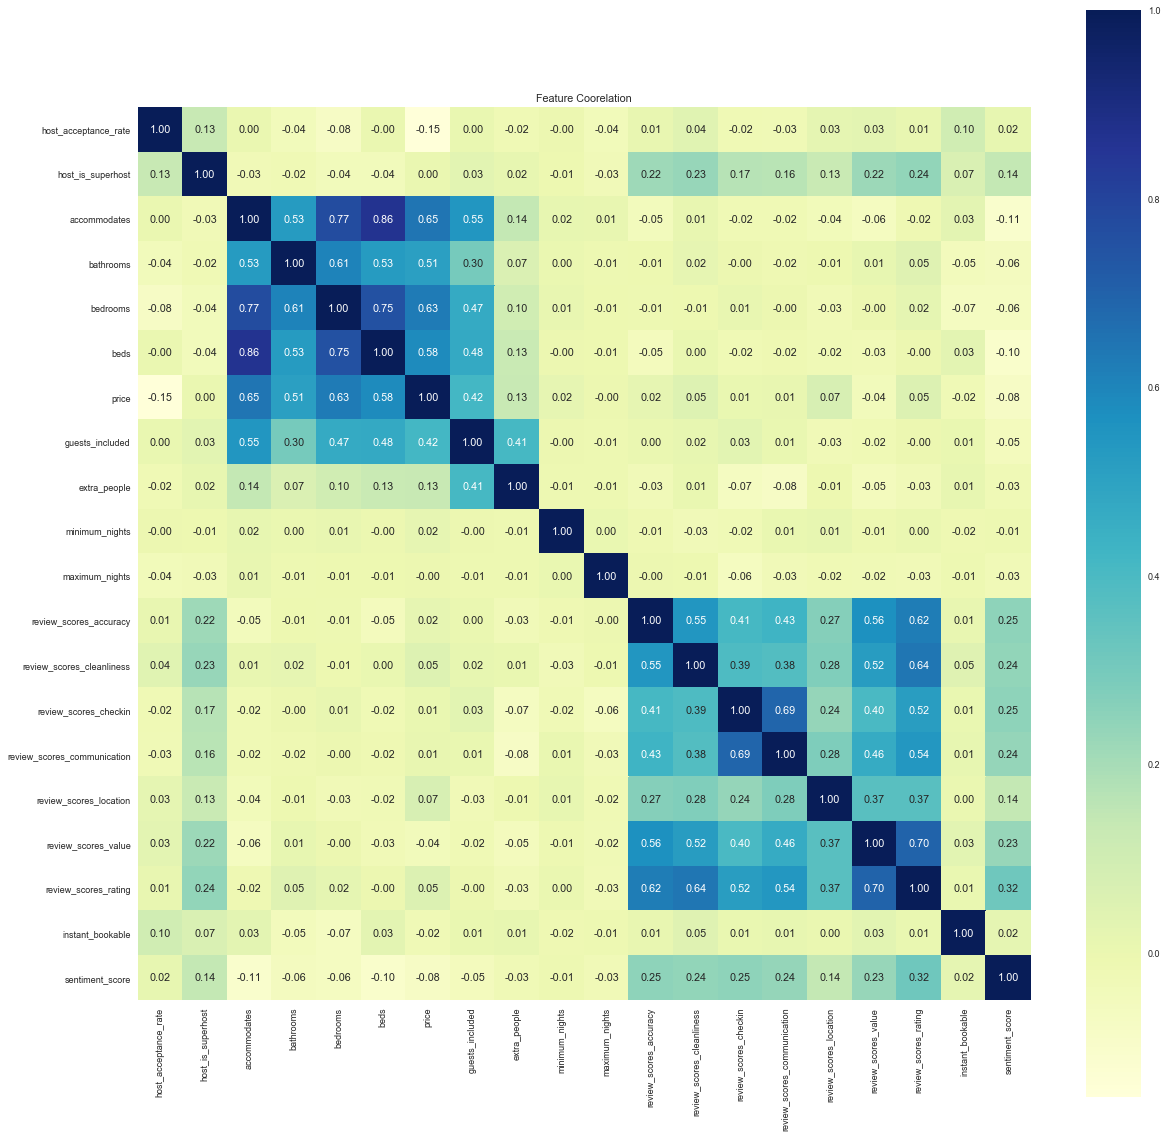

In [26]:
# Take a look at the correlation of the original numerical data:
init_cols = df.iloc[:, :20].columns.tolist()

corrs = np.corrcoef(df[init_cols].values.T)
sns.set(font_scale=.9)
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
ax.title.set_text('Feature Coorelation')
hm = sns.heatmap(corrs, cbar = True, 
                 cmap="YlGnBu", annot=True,
                 square = True, fmt = '.2f',
                 yticklabels = init_cols,
                 xticklabels = init_cols)

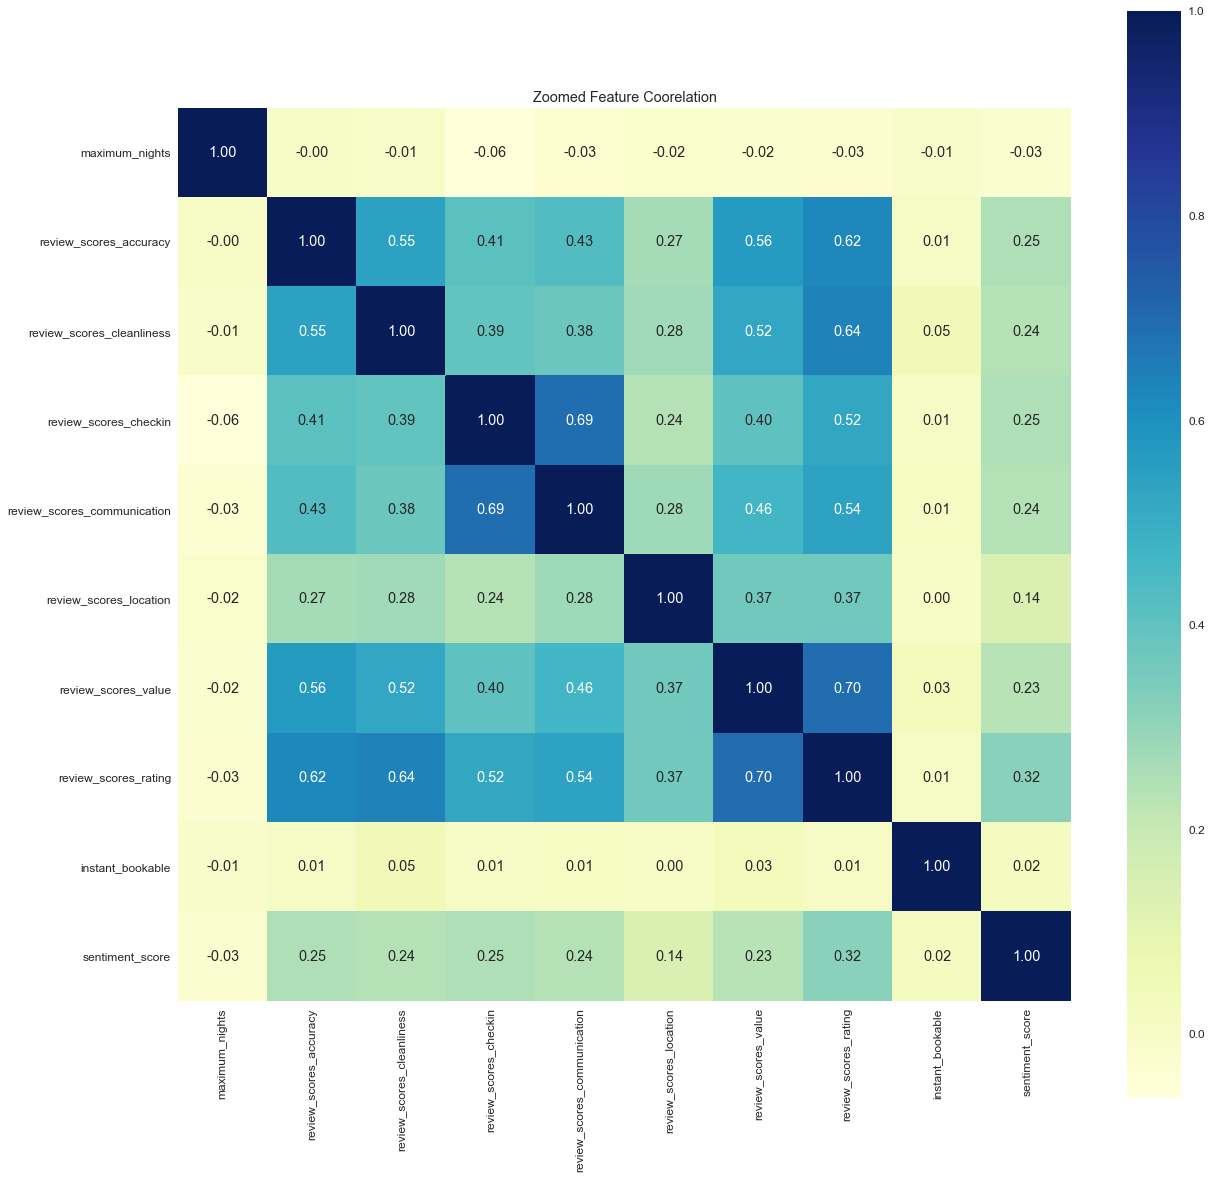

In [27]:
# Narrow in on review_scores_rating
init_cols = df.iloc[:, 10:20].columns.tolist()

corrs = np.corrcoef(df[init_cols].values.T)
sns.set(font_scale=1.2)
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
ax.title.set_text('Zoomed Feature Coorelation')
hm = sns.heatmap(corrs, cbar = True, 
                 cmap="YlGnBu", annot=True,
                 square = True, fmt = '.2f',
                 yticklabels = init_cols,
                 xticklabels = init_cols)

#### `Correlation Insight:`
`Even though there are other insightful correlations, the key column I want to focus on is` __`review_scores_rating`__. `The rest I'll leave up to you.`

> __`Strong Correlations`__:
    1. Value
    2. Cleaniness
    3. Accuracy
    4. Communication
    5. Checkin
    6. Location
    
> __`Weak Correlations`__: (`No Particular Order`)
    1. Price
    2. Extra People (Price for additional guests)
    3. Bathrooms
    4. Accomodates
    5. Max Nights
    6. Min Nights
    
___

### `Q2: Can we predict the the review score?`
#### `Purpose`

`My main focus on this analysis was to distinguish between a good review, bad review and what can be said about both. So, in order to do so, I had to convert this from a regression problem into a classification problem. I split the qualifying value by mean, 1 if it is above the mean and 0 if it is below the mean.`
`I also set other variables for future analysis to further pad the differences in the rating reviews so the comments will be more on the side of each good/bad review score:`

-  __`std_dev`__
-  __`top_pctl`__
-  __`bottom_pctl`__
-  __`df_top_reviews`__
-  __`df_bottom_reviews`__
 
__`NOTE`__:<br>
`Two seperate data sets were created by this seperation and will be used later in the analysis.`

---

In [28]:
# Set baseline for determining success and wanting
avg_rating = df['review_scores_rating'].mean()
avg_rating

94.55

In [29]:
# Get standard deviation to provide more padding for the threshold
std_dev = df['review_scores_rating'].std()

# Create two seperate dataframes based on below threshold
# Which will be used for 'name' and 'description' word analysis.
top_pctl = avg_rating + std_dev/1.75
bottom_pctl = avg_rating - std_dev/1.75
df_top_reviews = df[df['review_scores_rating'] >= top_pctl]
df_bottom_reviews = df[df['review_scores_rating'] <= bottom_pctl]

In [30]:
# Make this a classifiction problem
df['review_scores_rating'] = (df['review_scores_rating'] > avg_rating)* 1
df['review_scores_rating'].head()

id
241032     1
953595     1
3308979    1
278830     0
5956968    1
Name: review_scores_rating, dtype: int64

In [31]:
# Split predictor from rest of data:
y = df['review_scores_rating']
X = df.drop('review_scores_rating', axis=1)

In [32]:
# Suppress note output
pd.options.mode.chained_assignment = None 

# Adjust features to float for scaling:
X = X.astype('float')
y = y.astype('float')

# Save column names for predict importance analysis will focus on highest accuracy scores
Xcls = X.columns

# Scale data with MinMaxScaler 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [33]:
# Split to training and testing data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=21)
print(len(X_train), len(X_test))


2103 1037


In [34]:
pd.options.mode.chained_assignment = None 

def pred_rev(Xtrn, Xtst, ytrn, ytst):
    # Set algorithm parameters:
    rfc = RandomForestClassifier(bootstrap=True, class_weight=None, 
                                 criterion='gini', max_depth=20, 
                                 max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=4, min_samples_split=5,
                                 min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=8,
                                 oob_score=False, random_state=22, verbose=0, warm_start=False)

    # Fit the data
    rfc.fit(Xtrn, ytrn)

    # Predict:
    train_pred = rfc.predict(Xtrn)
    test_pred = rfc.predict(Xtst)

    # Measure:
    train_acc = accuracy_score(ytrn, train_pred)
    test_acc = accuracy_score(ytst, test_pred)

    
    return train_acc, test_acc, rfc

In [35]:
train_acc, test_acc, rfc = pred_rev(X_train, X_test, y_train, y_test)

print("Predicting Overall Review Rating:")
print("-"*33)
print("\tTrain Accuracy: {:.2%}\n\tTest Accuracy : {:.2%}".format(train_acc, test_acc))

Predicting Overall Review Rating:
---------------------------------
	Train Accuracy: 89.35%
	Test Accuracy : 84.67%


In [36]:
# Sample prediction
prediction = rfc.predict(X[2].reshape(1, -1))[0]

In [37]:
# Show listing details:
idx = y.index.values.tolist()[2]
details = df.loc[idx][df.loc[idx] >= 1]

In [38]:
actual = details.loc['review_scores_rating']

In [39]:
border = '-'*13
print("""
Id: {}
{}
Model Prediction: {}
{}
Actual Value: {}
""".format(idx, border, prediction, border, actual))


Id: 3308979
-------------
Model Prediction: 1.0
-------------
Actual Value: 1.0



#### `Prediction Insight`:
 `That's a pretty good prediction. That tells me that that the data, in terms of review_score_rating, has more insight to provide. I'd like to know what features were most important for this prediction. Luckily, this model has an attribute that will come in handy in that discovery.`
 
***

### `Q3: What features impact the review rating?`
#### `Purpose`
`See what impacts reviews top to bottom.`

In [40]:
# Create a dataframe for feature importance:
feature_importance = pd.DataFrame(rfc.feature_importances_,
                                  index = Xcls,
                                  columns=['Importance Pct.']).sort_values('Importance Pct.',
                                                                           ascending=False)

# Adjust column for readability:
feature_importance['Importance Pct.'] = feature_importance['Importance Pct.']*100
# Keep any feature that attributed to the predictions:
top_features = feature_importance.loc[feature_importance['Importance Pct.'] > 2]

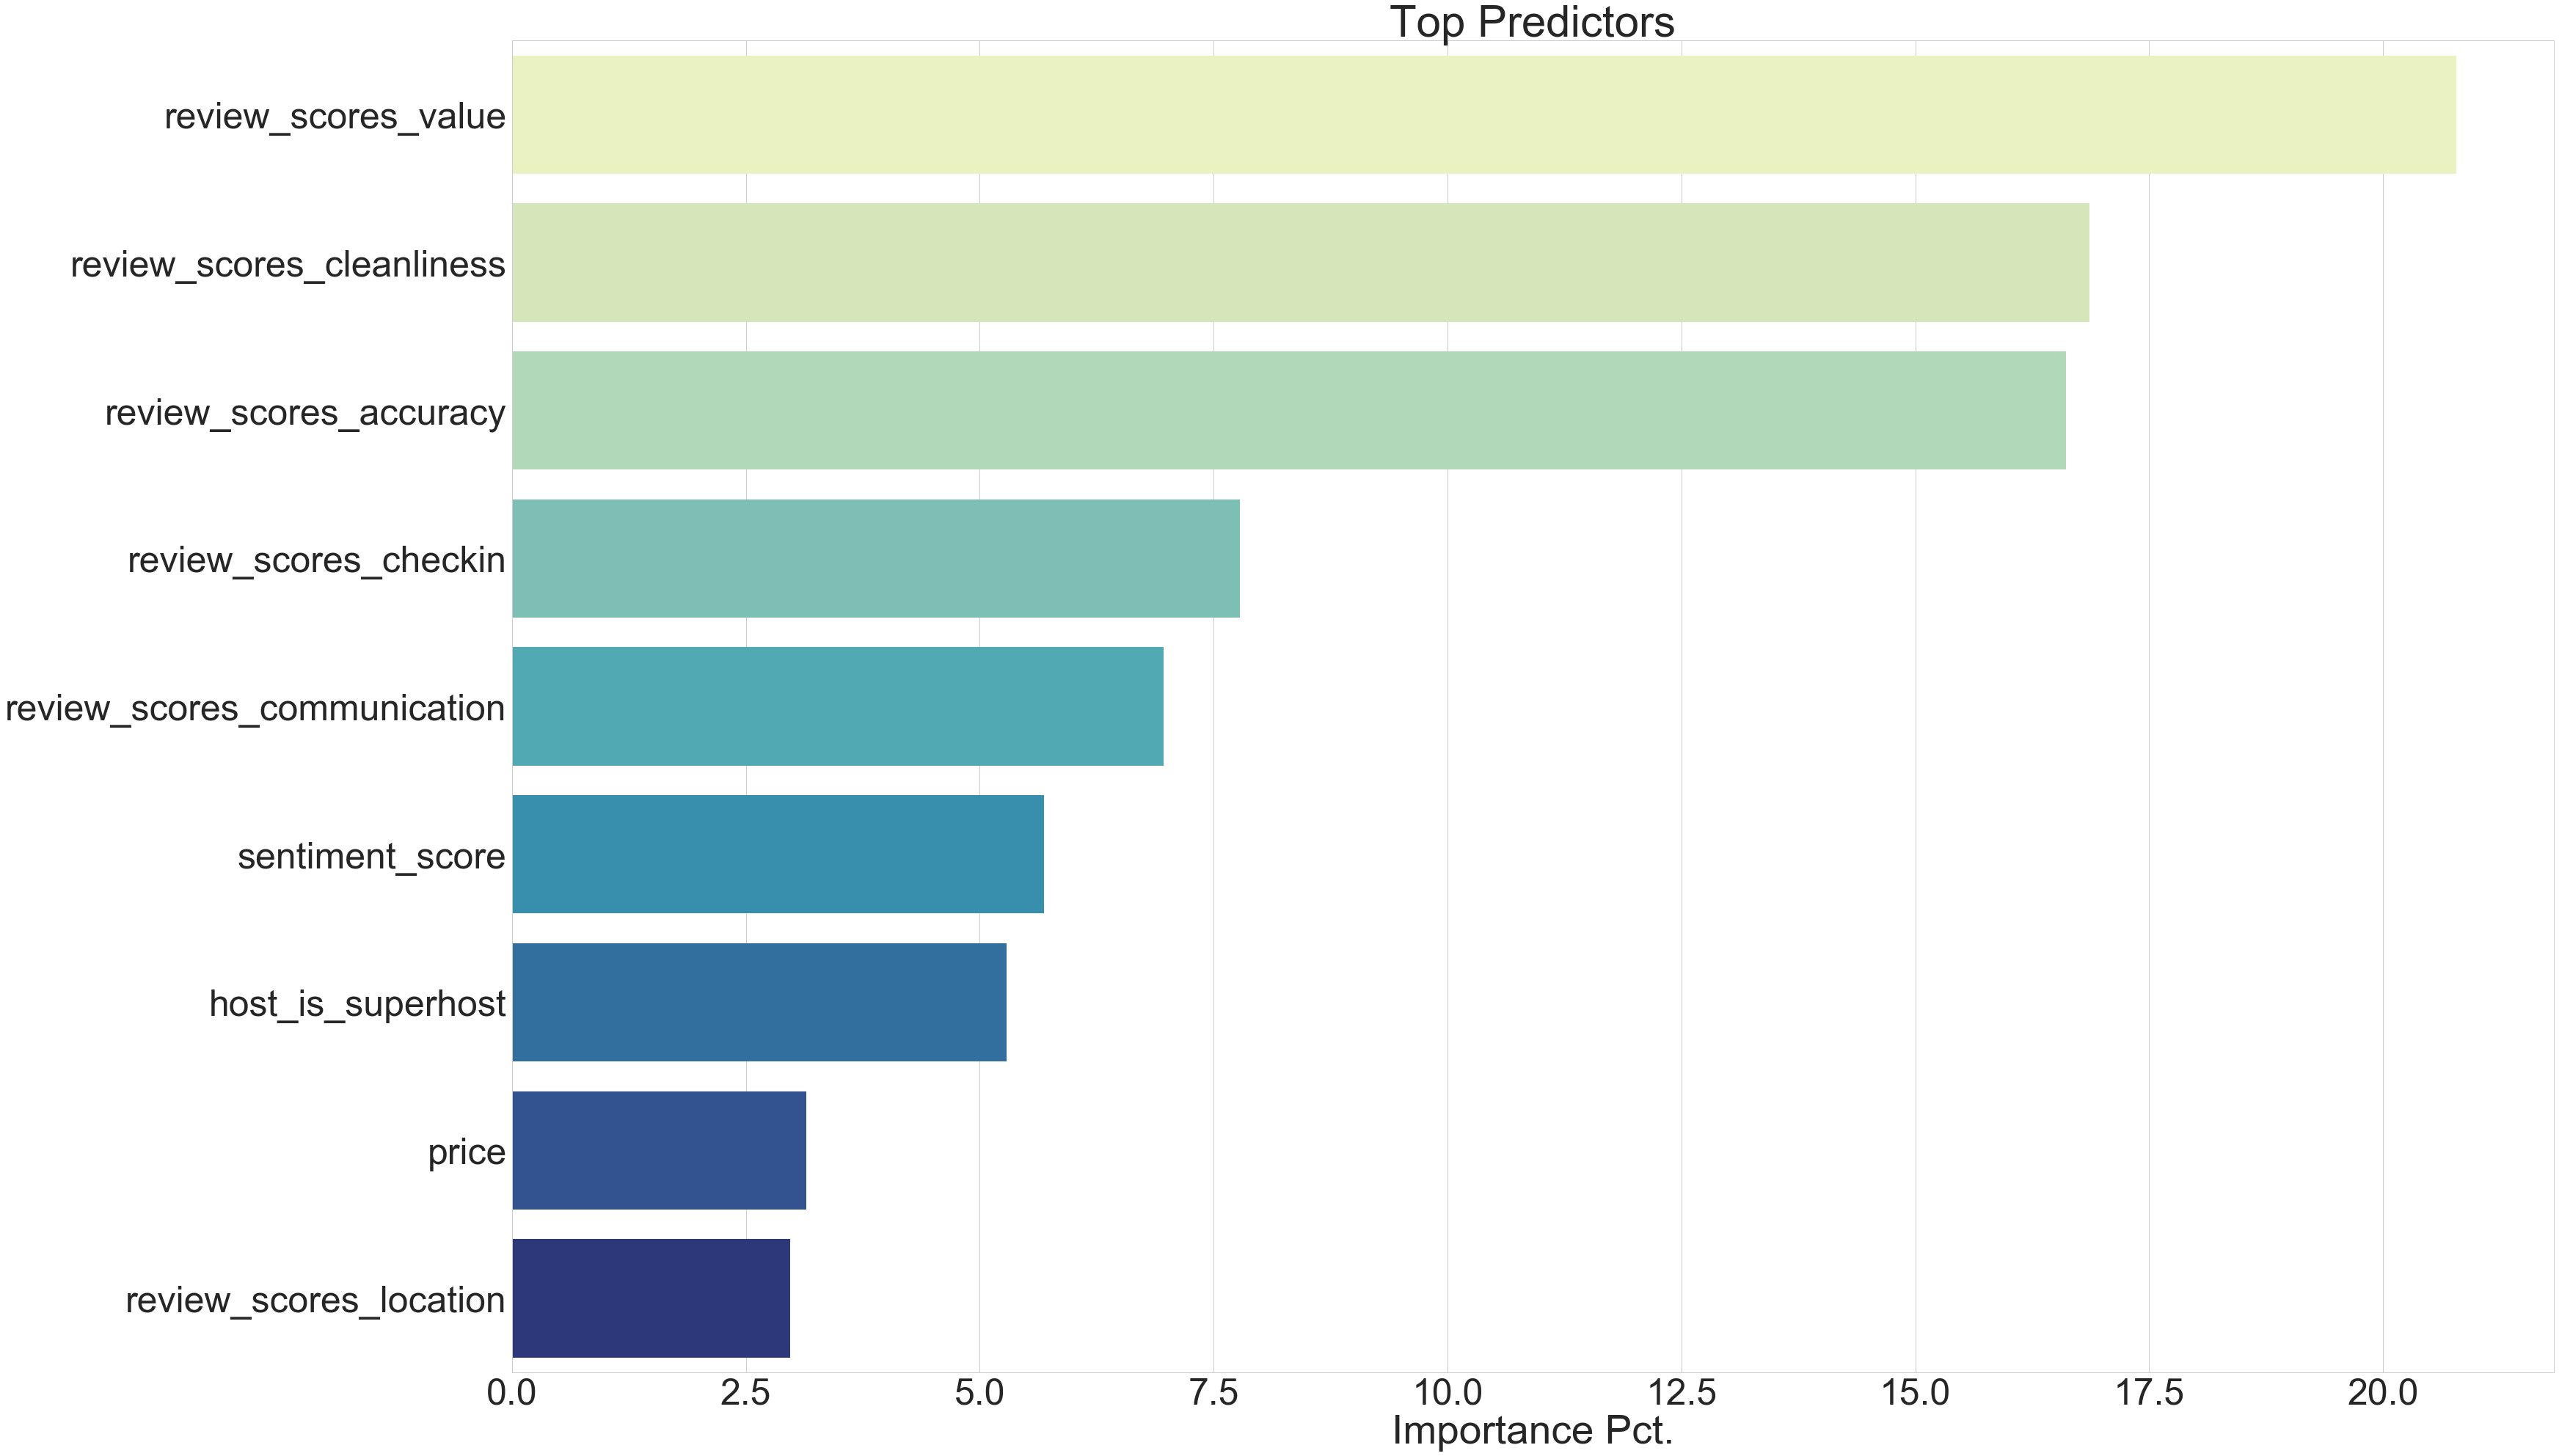

In [41]:
# Visualize:
sns.set(style='whitegrid', font_scale=5)
fig, ax = plt.subplots()
fig.set_size_inches(42, 28)
fig.tight_layout()
ax.title.set_text('Top Predictors')
sns.barplot(x=top_features['Importance Pct.'], 
            y=top_features.index,
            palette='YlGnBu');
plt.show()

#### `Feature Insight`:

`At first, glance looks similar to the correlation analysis, but with closer inspection, we can see some differences. To remind us what the ordered correlated features look like:`

    1. Value
    2. Cleaniness
    3. Accuracy
    4. Communication
    5. Checkin
    6. Location
    
`Here you see that` __`Value`__, __`Cleaniness`__ `and` __`Accuracy`__ `still hold the same positions, but` __`Checkin`__ `surpassed` __`Communication`__ `and` __`Sentiment`__ `overtook` __`Location`__. 

`Overall it looks like customers are looking for a` __`fairly priced`__, __`clean`__ `and` __`accurate`__ `listing with a smooth` __`check in`__ `and open` __`communication`__ `throughout the stay. All these factors will play into the` __`sentiment`__ `and the host being labeled as a` __`superhost`__. 
***

### `Q4: What are the customers saying about high/low rating listings and is there any insight to what impacted review scores?`

#### `Purpose`
`Get a more in depth perspective on the sentiment of these reviews and compare the differences between the two types`.

---

`For the sake of time and computing power, I decided to only pull a random sample of 75% of the comments from the data. This way we get an accurate interpretation of the comments left by customers in a minimal time frame.`

`Also, to further improve the compute time, we only look at the top ten comments of each listing. `

`I then use the previously created variables` __`df_top_reviews`__ `&` __`df_bottom_reviews`__ `to divide the data and generate a word cloud`.

In [42]:
def review_prep(_df, rev):
    idxs = _df.index.values.tolist()
    # Use idxs to select rows from the review data
    df_words = rev[rev.index.isin(idxs)].astype('str')
    # Keep only the top 10 reviews from each listing
    gby = df_words.groupby(df_words.index)['comments'].head(10)
    # Create a dataframe
    df_words = pd.DataFrame(gby)
    # Return a randomly select 80% of available comments
    return df_words.sample(frac=.80, random_state=28)

In [43]:
top_rev_words = review_prep(df_top_reviews, reviews)
top_rev_words.head()

,comments
7534300,Rick was an excellent host! He gave great reco...
7241905,"Great apartment! Clean, hosts made it very com..."
3793406,This was the perfect spot for my brother and I...
3238295,This was our first experience with air bnb and...
3768745,"If you can believe it, this place is even bett..."


In [44]:
# Repeat above for wanting listings:
bot_rev_words = review_prep(df_bottom_reviews, reviews)
bot_rev_words.head()

,comments
3498114,The place was clean and comfortable and struck...
84030,Marylin is a very nice lady and made us feel v...
1601714,"I too traveled to Seattle for a conference, a ..."
153967,My wife and I spent a week in July-2011 in thi...
1039766,This was exactly what I was looking for—a clea...


In [57]:
# Function to generate a stop list consisting of human names and other unexpected outcomes.
def stop_names():
    """
    Generate Stop Words from Names & Unexpected words
    
    Input: None
    Output: A list of stop words and names
    """
    male_names = names.words('male.txt')
    female_names = names.words('female.txt') 
    unexpected_words = ['thick', 'cor36', 'consummate', 
                        'doggie', 'huis', 'ying', 'pero',
                        'Qing', 'Miss', 'thin', 'molto',
                        'yurt', 'carriage', 'Yidian', 
                        'truck']
    names_list = male_names + female_names 
    names_list += unexpected_words
    return names_list

# Grab descriptive words from comments:
def filter_text(text):
    """
    Filter out descriptive words from a body of text.
    
    Input: A body of text.
    Output: A list of words that were parsed from punctuation.
    """
    token = nltk.word_tokenize(text)
    tags = ['VB', 'NN', 'VBP', 'JJ', 'VBG']
    words = [ word for word, lbl in nltk.pos_tag(token) if lbl in tags ]
    table = str.maketrans('', '', string.punctuation)
    return [w.translate(table) for w in words if w.isalpha()]


# Generate word clouds
def gen_wordcloud(col_name, review_type='positive'):
    """
    Generate WordCloud Image.
    
    Input: Column from the derived 'df_*_words' DataFrames.
    
    Output: First image - Above average word cloud from column name.
            Second image - Below average word cloud from column name.
    """
    
    # Join all values to a single string
    df_tj = ' '.join(top_rev_words[col_name])
    df_bj = ' '.join(bot_rev_words[col_name])
    
    successful_list = filter_text(df_tj)
    unsuccessful_list = filter_text(df_bj)

    tr = ' '.join([w for w in successful_list if w not in unsuccessful_list and len(w) > 3])
    br = ' '.join([w for w in unsuccessful_list if w not in successful_list and len(w) > 3])
    
    # Add above generated names to STOPWORDS:

    for name in stop_names():
        STOPWORDS.add(name)
    
    
    if review_type == 'positive':
        processed = tr
    elif review_type == 'negative':
        processed = br
    
    # Generate WordClouds
    wc = WordCloud(stopwords = STOPWORDS,
                   background_color='white',
                   height=1500,
                   colormap='viridis',
                   random_state=21,
                   width=4000,
                   max_words=150).generate(processed)
    

    # Display images:
    plt.ioff();
    fig = plt.figure(figsize = (16, 4), dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(wc);
    plt.title('{} {} Review'.format(review_type.capitalize(), col_name.capitalize()), fontsize = 10);
    plt.axis('off');
    plt.show;

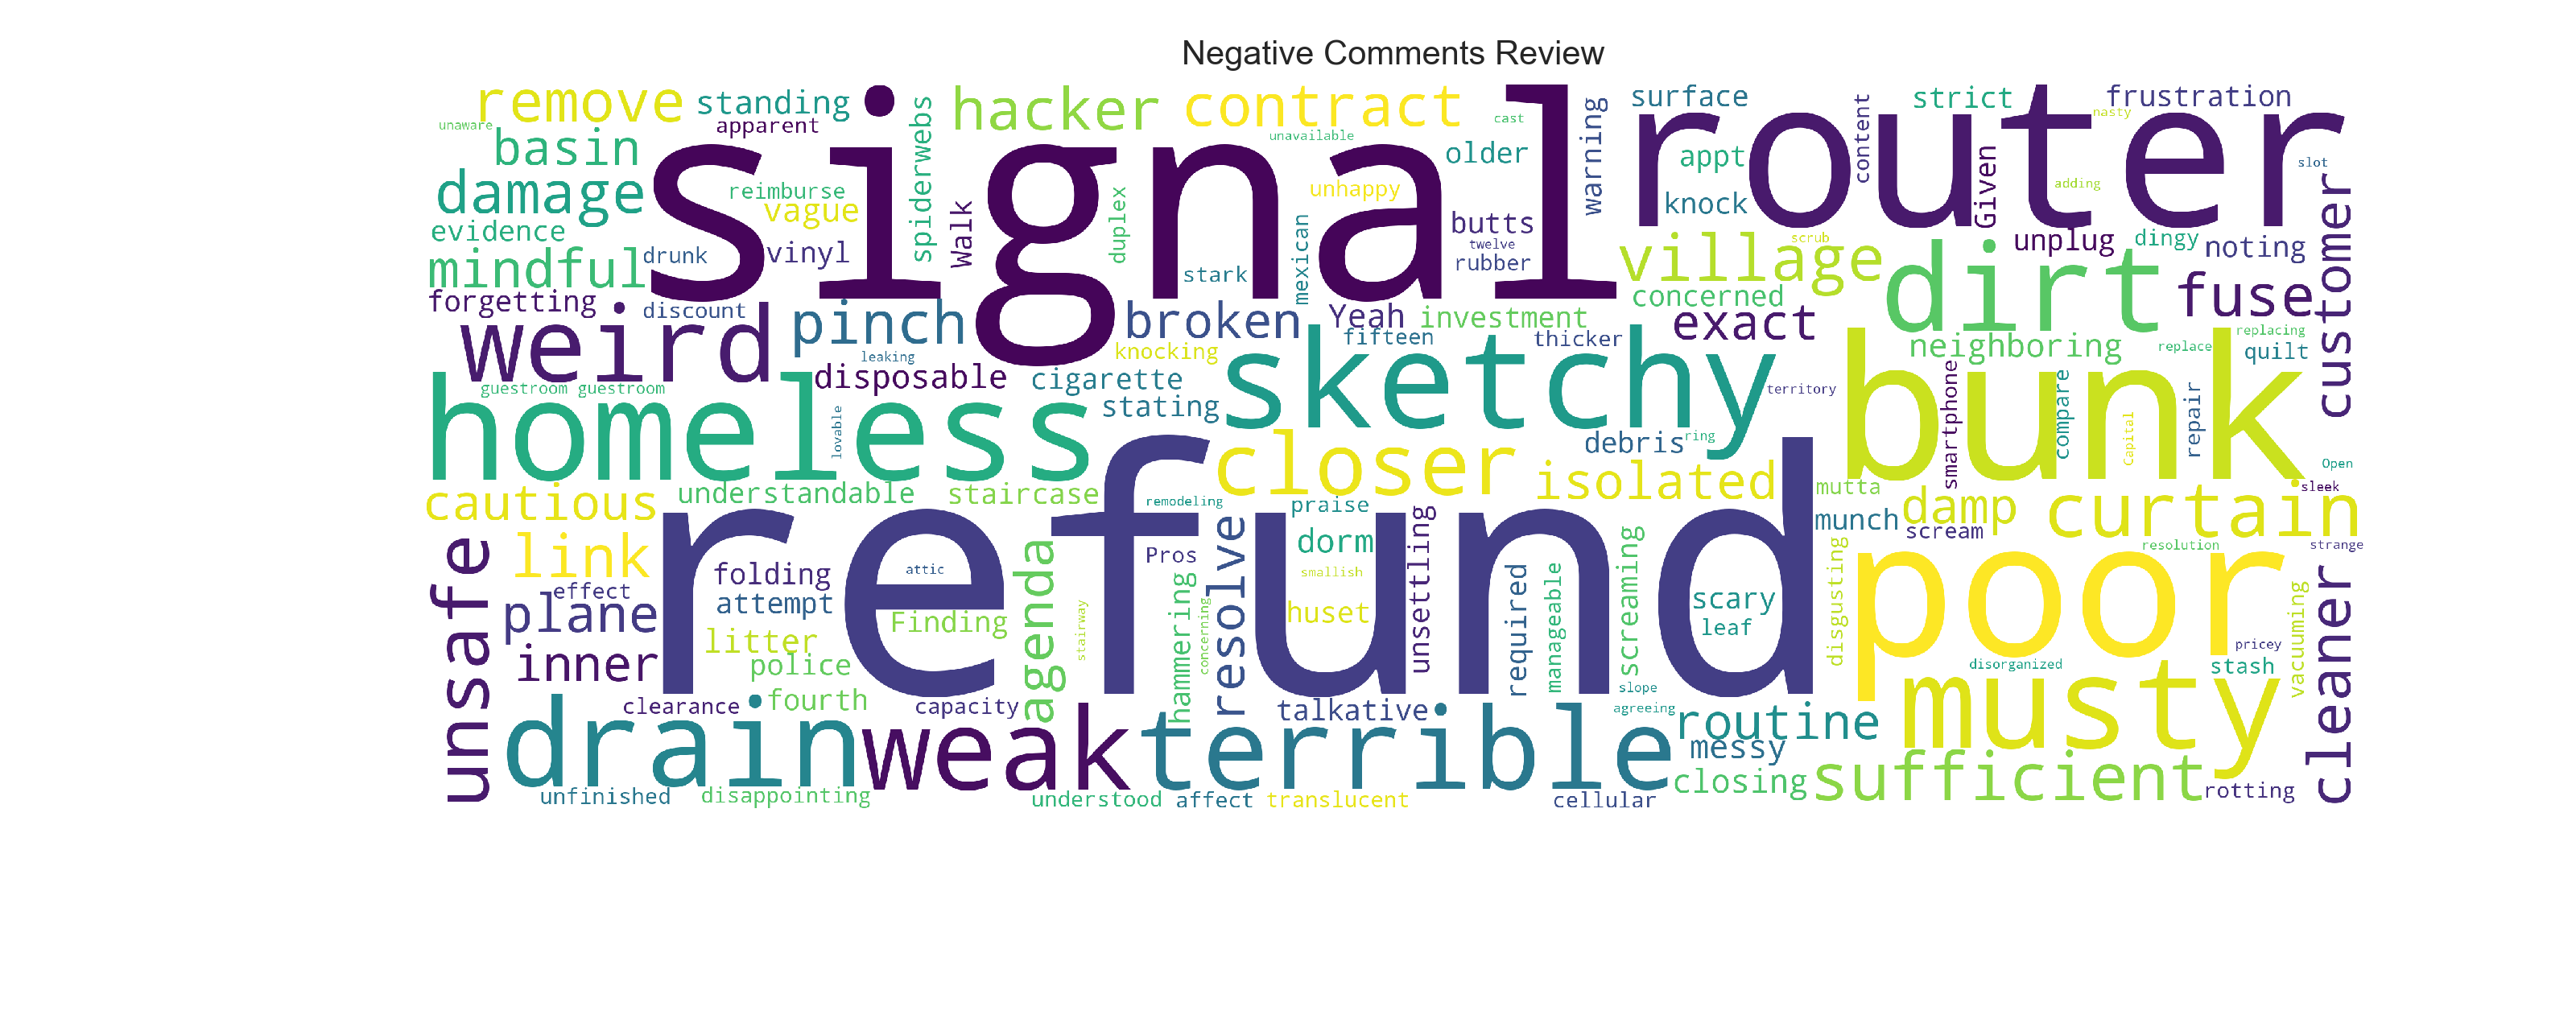

In [58]:
# Generate a negative review word cloud:
gen_wordcloud('comments', 'negative')

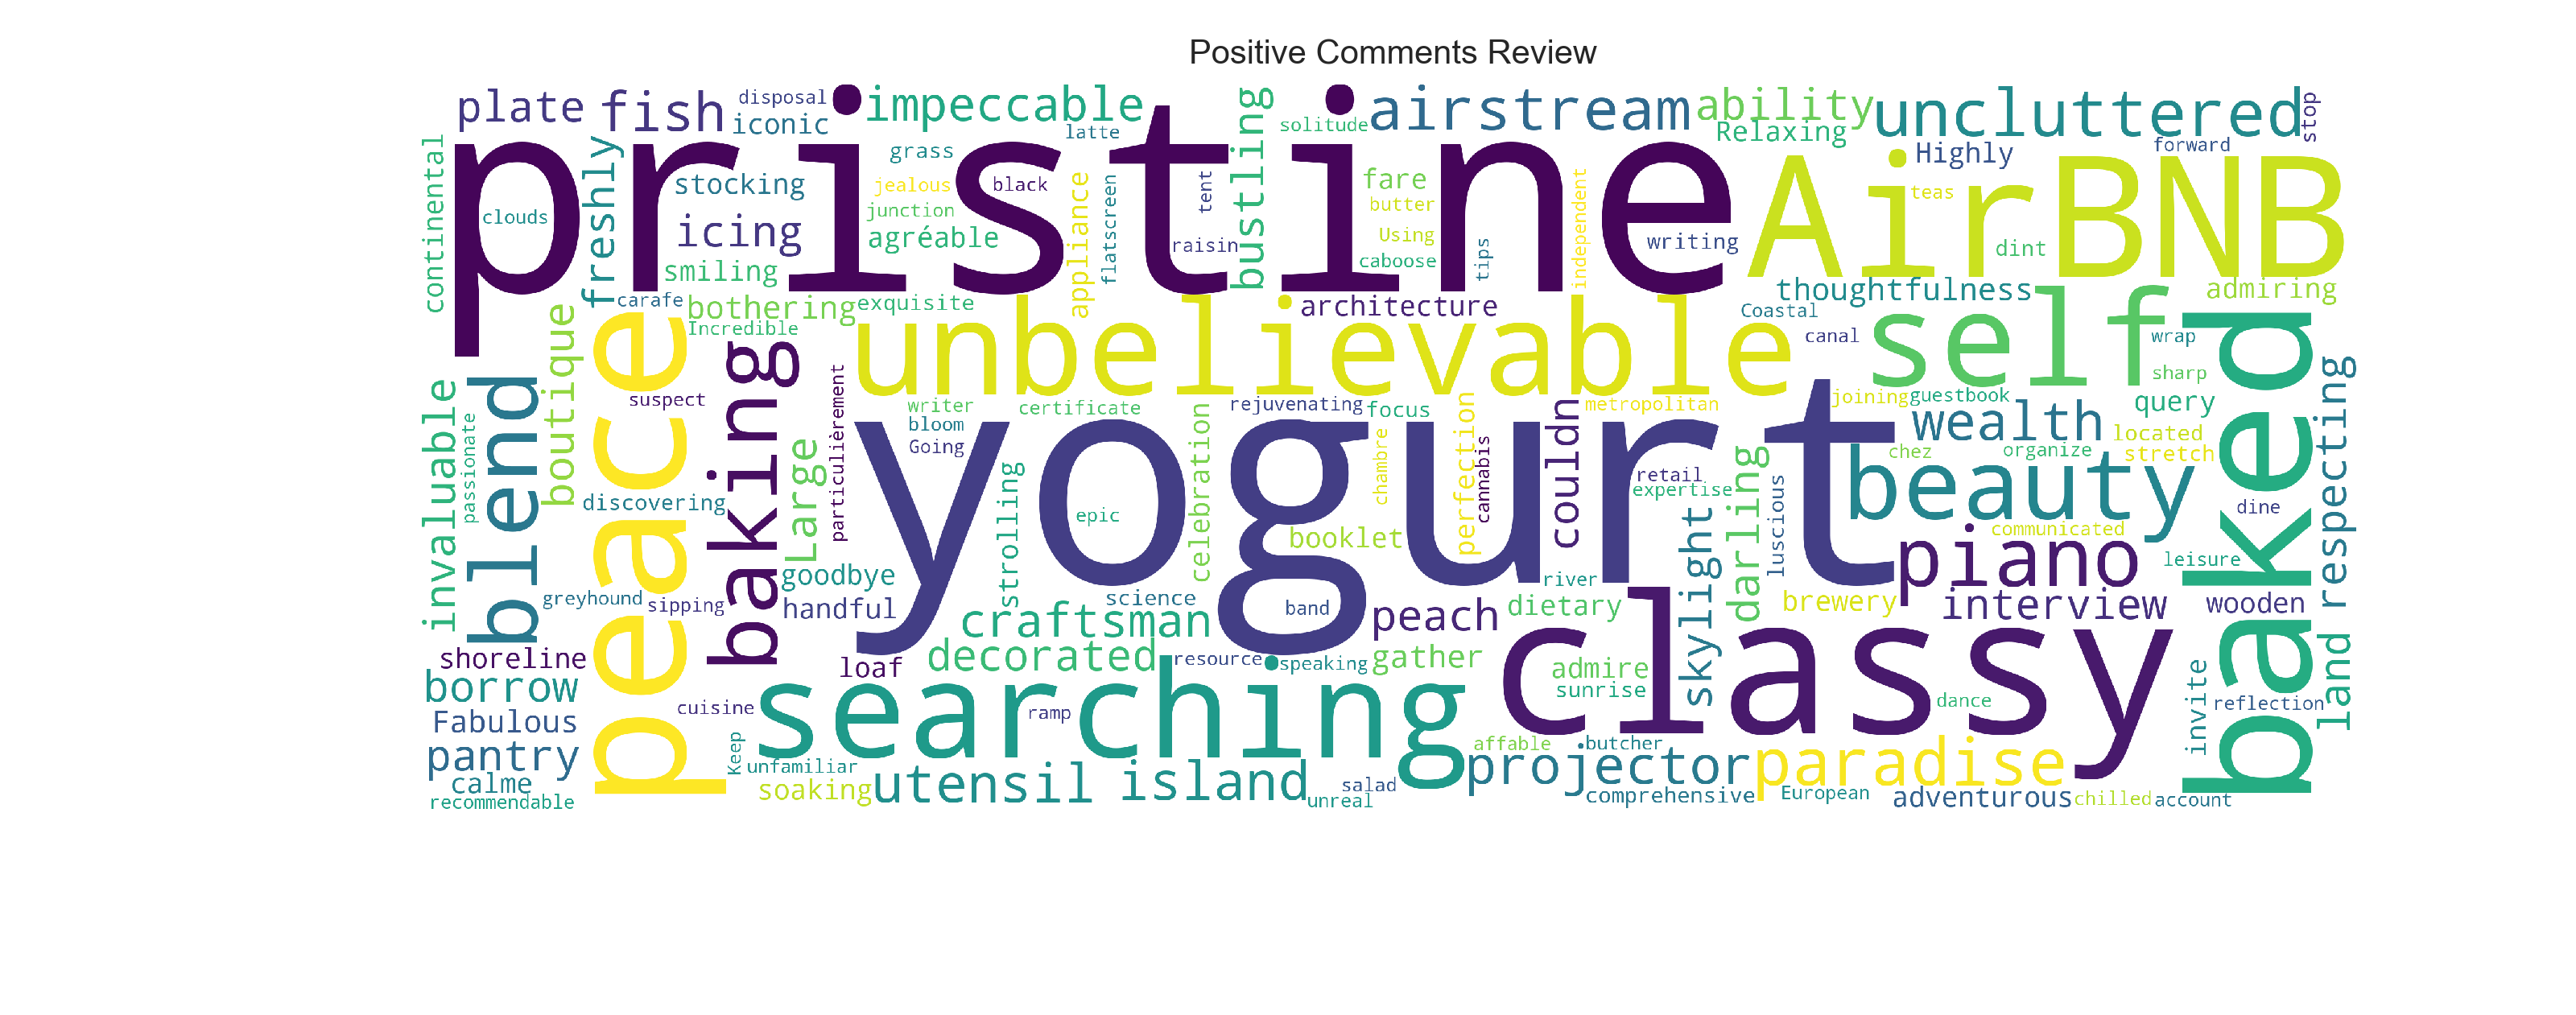

In [59]:
# Generate a positive review word cloud:
gen_wordcloud('comments');


####  `Word cloud insight`:
`To properly analyze the images please reference the insight gained in the previous section:`

`Overall it looks like customers are looking for a` __`value priced`__, __`clean`__ `and` __`accurate`__ `listing with a smooth` __`check-in`__ `and open` __`communication`__ `throughout the stay. All these factors will play into the` __`sentiment`__`, the host being labeled as a` __`super host`__ `and of course the` __`review score`__.
       
       
`It is pretty cool to see the keywords for each type of review. With this, we can get a clear idea of what makes a review either positive or negative.`
***

## `Summation`:
`The completed analysis is suspect to my experience, which may have led to less than optimal decisions. Nonetheless, I feel confident in the completed notebook and believe this can help those who are just getting started in data science or are considering listing on Airbnb.`

   __`1.` `Detected Correlated features`__ <br>

   __`2.` `Successfully predicted the review rating.`__ <br>

   __`3.` `Enumerated critical features to predict the rating. Thereby, finding what is important to the customers.`__ <br>

   __`4.` `In order to get a better idea of what makes these reviews tick I generated a word cloud for each type of review (Positive, negative).`__ <br>

`Finally, we can see what aspects are important in achieving a high review rating. In short, keep the property clean and ordered, be honest in the description, price it accordingly and make sure to communicate with the guest throughout. Also, a little` __*`thoughtfulness`*__ `goes a long way. So, if possible, go a little bit out of your way to make the guest feel` __*`appreciated`*__ `with a` __*`prestine`*__ `presentation of` __*`baked`*__ `goodies and a` __*`handful`*__ of __*`yogurt`*__ `in the fridge and you'll be sure to have an` __*`unbelievable`*__ `review.`

Thank you,
